<a href="https://colab.research.google.com/github/harvey2phase/rrh/blob/main/RRH_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Definitions

In [2]:
LAT_DIM = 2
EPOCH_NUM = 35
BATCH_SIZE = 128
CAPACITY = 64
LRN_RATE = 1e-3
VAR_BETA = 1

KERN_SIZE = 4
STRIDE = 2
PAD = 1

GPU = True

## VAE

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # CAPACITY * 14 * 14
        self.conv1 = nn.Conv2d(
            in_channels = 1,
            out_channels = CAPACITY,
            kernel_size = KERN_SIZE,
            stride = STRIDE,
            padding = PAD,
        )
        # CAPACITY * 7 * 7
        self.conv2 = nn.Conv2d(
            in_channels = CAPACITY,
            out_channels = CAPACITY * 2,
            kernel_size = KERN_SIZE,
            stride = STRIDE,
            padding = PAD,
        )
        self.fc_mu = nn.Linear(
            in_features = CAPACITY * 2 * 7 * 7,
            out_features = LAT_DIM,
        )
        self.fc_logvar = nn.Linear(
            in_features = CAPACITY * 2 * 7 * 7,
            out_features = LAT_DIM,
        )
        
    def forward(self, x):
        x = functional.relu(self.conv2(
            functional.relu(self.conv1(x))
        ))
        x = x.view(x.size(0), -1)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

In [4]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc = nn.Linear(
            in_features = LAT_DIM,
            out_features = CAPACITY * 2 * 7 * 7,
        )
        self.conv2 = nn.ConvTranspose2d(
            in_channels = CAPACITY * 2,
            out_channels = CAPACITY,
            kernel_size = KERN_SIZE,
            stride = STRIDE,
            padding = PAD,
        )
        self.conv1 = nn.ConvTranspose2d(
            in_channels = CAPACITY,
            out_channels = 1,
            kernel_size = KERN_SIZE,
            stride = STRIDE,
            padding = PAD,
        )

    def forward(self, x):
        x = self.fc(x)
        return torch.sigmoid(self.conv1(
                functional.relu(self.conv2(
                    x.view(x.size(0), CAPACITY * 2, 7, 7)
            ))
        ))

In [5]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

In [6]:
def reconstruction_erorr(recon_x, x):
    return functional.binary_cross_entropy(
        recon_x.view(-1, 784),
        x.view(-1, 784),
        reduction = "sum",
    )

def vae_loss(recon_loss, mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + VAR_BETA * kl_divergence

## RRH for Gaussian Mixtures

In [7]:
def mvn_renyi(C, q=1):
    """ Computes the Rényi heterogeneity for a multivariate Gaussian 
    Arguments: 
        C: `ndarray((n,n))`. Covariance matrix
        q: `0<float`. Order of the heterogeneity
    Returns: 
        `float`
    """
    n = C.shape[0]
    SqrtDetC = np.sqrt(np.linalg.det(C))
    if q == 1: 
        out = (2*np.pi*np.e)**(n/2) * SqrtDetC
    elif q == np.inf: 
        out = (2*np.pi)**(n/2) * SqrtDetC
    elif q!=1 and q!=0 and q!=np.inf:
        out = ((2*np.pi)**(n/2))*(q**(n/(2*(q-1))))*SqrtDetC
    return out

In [8]:
def mvn_renyi_alpha(C,  q=1):
    """ Computes the alpha-heterogeneity for a Gaussian mixture where each sample has equal weight

    Arguments: 

        cov: `ndarray((nsamples, n, n))`. Covariance matrices 
        q: `0<float`. Order of the heterogeneity metric

    Returns: 

        `float`. The alpha-heterogeneity
    """
    K, n, _ = C.shape
    p = np.repeat(1/K, K)
    if q == 1:
        out = np.exp((n + np.sum(p*np.log(np.linalg.det(2*np.pi*C))))/2)
    elif q!=np.inf and q!=1 and q!=0:
        wbar = (p**q)/np.sum(p**q)
        out = ((2*np.pi)**(n/2))*np.sum(wbar*np.sqrt(np.linalg.det(C)))/(q**(n/2))**(1/(1-q))
    return out


In [9]:
def scale_to_cov(scales):
    return np.vstack([np.expand_dims(np.diagflat(s), 0) for s in scales])

In [10]:
def pool_covariance(means, covs):
    K = covs.shape[0] 
    p = np.repeat(1/K, K)
    cov_ = np.einsum('ijk,i->jk', covs, p) + np.einsum('ij,ik,i->jk', means, means, p)
    mu_ = np.einsum('ij,i->j', means, p)
    return cov_ - np.einsum('i,j->ij', mu_, mu_)

## VAE Training and Evaluation



In [11]:
device = torch.device("cuda:0" if GPU and torch.cuda.is_available() else "cpu")

In [12]:
def plot_loss(train_loss, test_loss, i = 0, y = "Loss"):
    plt.ion()

    fig = plt.figure(i)
    plt.plot(train_loss, c = "blue", label = "training")
    plt.plot(test_loss, c = "red", label = "evaluation")
    plt.xlabel('Epochs')
    plt.ylabel(y)
    plt.legend()
    plt.show()

In [13]:
def eval_model(vae):
    vae.eval()
    
    test_loss_avg, test_recon_loss_avg, num_batches = 0, 0, 0
    for image_batch, _ in test_dataloader:
        
        with torch.no_grad():
        
            image_batch = image_batch.to(device)
    
            # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
    
            # reconstruction error
            recon_loss = reconstruction_erorr(image_batch_recon, image_batch)
            loss = vae_loss(recon_loss, latent_mu, latent_logvar)
    
            test_recon_loss_avg += recon_loss
            test_loss_avg += loss.item()
            num_batches += 1
        
    test_recon_loss_avg /= num_batches
    test_loss_avg /= num_batches

    return test_recon_loss_avg, test_loss_avg
    #print('average reconstruction error: %f' % (test_recon_loss_avg))
    #print('average error: %f' % (test_loss_avg))

In [14]:
def train_one_model(evaluate = False):
    """ Creates and trains one VAE model.

    Args:
        evaluate: Whether or not to evaluate model during training.

    Returns:
        Tuple containing the trained model, average training reconstruction
        error, average total training error, average testing reconstruction
        error, and average total testing error.
    """

    vae = VariationalAutoencoder()
    vae = vae.to(device)
    
    num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
    print('Number of parameters: %d' % num_params)
    
    optimizer = torch.optim.Adam(
        params = vae.parameters(),
        lr = LRN_RATE,
        weight_decay = 1e-5,
    )
    
    # set to training mode
    vae.train()
    
    train_recon_loss, train_loss = [], []
    test_recon_loss, test_loss = [], []
    
    print("Training: ", end = "")
    for epoch in range(EPOCH_NUM):
        train_recon_loss.append(0)
        train_loss.append(0)
        num_batches = 0
        
        for image_batch, _ in train_dataloader:
            
            image_batch = image_batch.to(device)
    
            # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
            
            # reconstruction error
            recon_loss = reconstruction_erorr(image_batch_recon, image_batch)
            loss = vae_loss(recon_loss, latent_mu, latent_logvar)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            
            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()
            
            train_recon_loss[-1] += recon_loss
            train_loss[-1] += loss.item()
            num_batches += 1
            
        train_recon_loss[-1] /= num_batches
        train_loss[-1] /= num_batches

        if evaluate:
            recon_loss_avg, loss_avg = eval_model(vae)
            test_recon_loss.append(recon_loss_avg)
            test_loss.append(loss_avg)
            vae.train()
        
        print("%d, " % (epoch+1), end = "")
        
    print()
    if evaluate: 
        plot_loss(train_loss, test_loss)
        plot_loss(train_recon_loss, test_recon_loss, y = "Reconstruction Error")
    else:
        test_recon_loss, test_loss = None, None
        
    return vae, train_recon_loss, train_loss, test_recon_loss, test_loss

In [15]:
# matrix[i] is the heterogeneity array for vae_i
# matrix[i][j] is the heterogeneity for digit_j for vae_i

def train_and_test_models(n, gamma_matrix, alpha_matrix, beta_matrix):
    for _ in range(n):
        vae, _, _, _, _ = train_one_model(evaluate = True)
        
        gammas, alphas, betas = calculate_rrh(vae)
        gamma_matrix.append(gammas)
        alpha_matrix.append(alphas)
        beta_matrix.append(betas)
    return gamma_matrix, alpha_matrix, beta_matrix

def plot_rrh_matrices(gamma_matrix, alpha_matrix, beta_matrix):
    gamma_avg = het_avg(gamma_matrix)
    alpha_avg = het_avg(alpha_matrix)
    beta_avg = het_avg(beta_matrix)
    
    gamma_sigma = het_sigma(gamma_matrix)
    alpha_sigma = het_sigma(alpha_matrix)
    beta_sigma = het_sigma(beta_matrix)
    
    plot_rrh(
        gamma_avg, alpha_avg, beta_avg,
        sigmas = [gamma_sigma, alpha_sigma, beta_sigma],
    )

## Compute and plot RRH for VAE

In [16]:
def calculate_rrh(vae):
    gammas = []
    alphas = []
    betas = []
    for i in range(10):
        mu, logvar = vae.encoder(torch.Tensor(X[y == i]).to(device))
        loc = mu.cpu().detach().numpy()
        scale = logvar.exp().cpu().detach().numpy()
        cov = scale_to_cov(scale)
        cov = scale_to_cov(scale)
        gamma = mvn_renyi(pool_covariance(loc, cov), q=1)
        alpha = mvn_renyi_alpha(cov,q=1)
        beta = gamma/alpha
        gammas.append(gamma)
        alphas.append(alpha)
        betas.append(beta)
    return np.array(gammas), np.array(alphas), np.array(betas)

In [17]:
def plot_rrh(gammas, alphas, betas, sigmas = None):
    if not (len(gammas) == len(alphas) or len(gammas) == len(betas)):
        sys.exit("Mismatched matrix size")
    n = len(gammas)
    hetvalues = [gammas, alphas, betas]
    plotlabels = [r"Pooled", r"Within-Observation", r"Between-Observation"]
    
    fig, ax = plt.subplots(ncols=3, figsize=(9, 2.5))
    ax[0].set_ylabel("Heterogeneity")
    
    for i in range(3): 
        ax[i].set_title(plotlabels[i])
        ax[i].set_xlabel("Digit")
        ax[i].set_xticks(np.arange(10))
        ax[i].set_xticklabels(np.arange(10))
        ax[i].bar(
            np.arange(10),
            hetvalues[i],
            facecolor = plt.get_cmap("Greys")(0.4), 
            edgecolor = "black",
        )
        if not sigmas == None:
            ax[i].errorbar(
                np.arange(10),
                hetvalues[i],
                yerr = sigmas[i],
                fmt = "none",
                ecolor = "r",
                capsize = 3,
                label = "std deviation",
            )
            ax[i].errorbar(
                np.arange(10),
                hetvalues[i],
                yerr = sigmas[i] / np.sqrt(n),
                fmt = "none",
                ecolor = "b",
                capsize = 3,
                label = "std error",
            )
    plt.tight_layout()
    plt.savefig("digit-class-heterogeneity.pdf", bbox_inches="tight")

# MNIST Experiments

## Make MNIST training and evaluation sets

In [18]:
img_transform = transforms.Compose([
    transforms.ToTensor()
])

def load_mnist(train):
    dataset = MNIST(
        root = './data/MNIST',
        download = True,
        train = train,
        transform = img_transform,
    )
    return DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)

train_dataloader = load_mnist(train = True)
test_dataloader = load_mnist(train = False)

In [19]:
# Place into numpy arrays for easier manipulation
traindata = list(train_dataloader)
traindata = [[sample[0].numpy(), sample[1].numpy()] for sample in traindata]
X = np.vstack([sample[0] for sample in traindata])
y = np.hstack([sample[1] for sample in traindata])

In [20]:
def het_sigma(matrix, avg = None):
    if avg == None:
        avg = het_avg(matrix)
    n = len(matrix)
    mse = (matrix[0] - avg) ** 2
    for i in range(1, n):
        mse += (matrix[i] - avg) ** 2
    return np.sqrt(mse / n)

def het_sum(matrix):
    sum = matrix[0] + matrix[1]
    for i in range(2, len(matrix)):
        sum += matrix[i]
    return sum

def het_avg(matrix):
    return het_sum(matrix) / len(matrix)

# Experiments

Number of parameters: 308357
Training: 1, 2, 


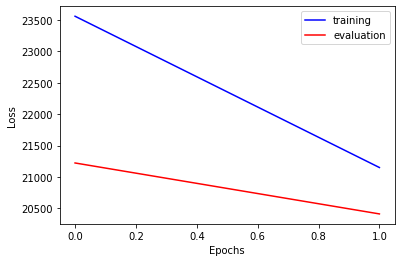

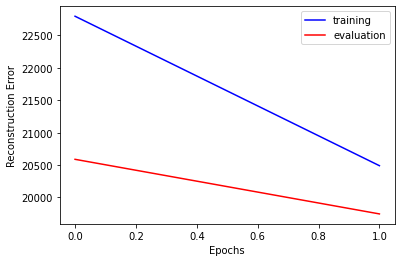

Number of parameters: 308357
Training: 

In [ ]:
N = 3
n = 5
gamma_matrix, alpha_matrix, beta_matrix = [], [], []
for _ in range(N):
    gamma_matrix, alpha_matrix, beta_matrix = train_and_test_models(
        n, gamma_matrix, alpha_matrix, beta_matrix,
    )
    plot_rrh_matrices(gamma_matrix, alpha_matrix, beta_matrix)

## Load, Evaluate, and Plot RRH for Pre-Trained VAE

In [ ]:
def load_pretrained_vae():
    pretrained_vae = VariationalAutoencoder()
    pretrained_vae = pretrained_vae.to(device)
    
    filename = 'vae_2d.pth'
    
    if not os.path.isdir('./pretrained'):
        os.makedirs('./pretrained')
    urllib.request.urlretrieve(
        "http://geometry.cs.ucl.ac.uk/creativeai/pretrained/" + filename,
        "./pretrained/" + filename,
    )
    pretrained_vae.load_state_dict(torch.load('./pretrained/' + filename))
    return pretrained_vae

In [ ]:
pretrained_vae = load_pretrained_vae()
eval_model(pretrained_vae)

In [ ]:
gammas, alphas, betas = calculate_rrh(pretrained_vae)
plot_rrh(gammas, alphas, betas)